In [1]:
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import transforms, models

In [9]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = Image.open("Bullmastiff.jpg").convert('RGB')
img_tensor = preprocess(img)

In [11]:
img_tensor = preprocess(img)
input_tensor = img_tensor.unsqueeze(0)

In [12]:
model = models.resnet50(pretrained=True)
model.eval()

/home/AD.IGD.FRAUNHOFER.DE/asullah/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/AD.IGD.FRAUNHOFER.DE/asullah/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
target_layer = model.layer4[-1]
activations = []
gradients = []
def forward_hook(module, input, output):
    activations.clear()
    activations.append(output)
def backward_hook(module, grad_input, grad_output):
    gradients.clear()
    gradients.append(grad_output[0])
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

In [14]:
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
model.zero_grad()
output[0, pred_class].backward()
if not gradients or not activations:
    raise RuntimeError("Hooks didn't trigger. Check hook registration and input path.")

In [15]:
activation = activations[0].squeeze(0)
weights = torch.mean(gradients[0], dim=[2, 3]).squeeze(0)
heatmap = torch.sum(weights[:, None, None] * activation, dim=0)
heatmap = heatmap.cpu().detach().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

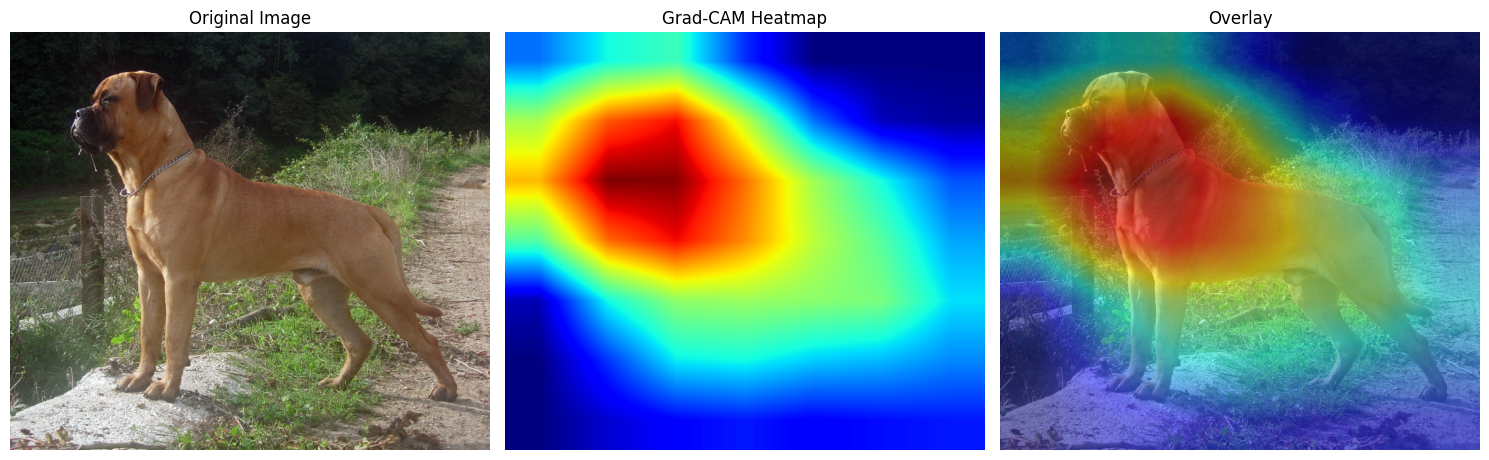

In [16]:
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms.functional import to_pil_image
heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
img_np = np.array(img)
overlay = cv2.addWeighted(img_np, 0.5, heatmap_color, 0.5, 0)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Grad-CAM Heatmap')
plt.imshow(heatmap_resized, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.savefig("gradcam_results.png", dpi=300)  # save first
plt.show()  # then display
